In [10]:
import glob
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Load the contents
with open("train_metrics_20251018_1705.jsonl", "r") as f:
    train_metrics = [json.loads(line) for line in f]

df_metrics = pd.DataFrame(train_metrics)
df_metrics

,step,train_loss,val_loss,hellaswag_acc,norm,tokens_per_second,lr,shard_index
0,0,11.035949,11.036964,NaN,0.000000,1409.945040,0.000000e+00,edufineweb_train_000006.npy
1,8,11.014856,NaN,NaN,0.000000,42812.707972,0.000000e+00,edufineweb_train_000010.npy
2,16,11.043348,NaN,NaN,7.396093,30134.446936,7.978723e-07,edufineweb_train_000120.npy
3,24,10.998390,NaN,NaN,7.396093,42821.565111,7.978723e-07,edufineweb_train_000081.npy
4,32,10.963530,NaN,NaN,7.398496,46979.752750,1.595745e-06,edufineweb_train_000084.npy
...,...,...,...,...,...,...,...,...
19363,154904,3.022054,NaN,NaN,0.242627,45689.845281,1.622882e-04,edufineweb_train_000008.npy
19364,154912,2.979841,NaN,NaN,0.246369,46699.782222,1.622651e-04,edufineweb_train_000040.npy
19365,154920,2.996284,NaN,NaN,0.246369,45740.450301,1.622651e-04,edufineweb_train_000174.npy
19366,154928,3.066065,NaN,NaN,0.245921,46639.350874,1.622420e-04,edufineweb_train_000171.npy


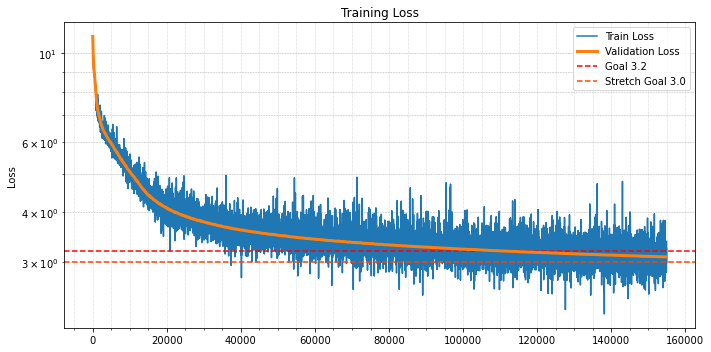

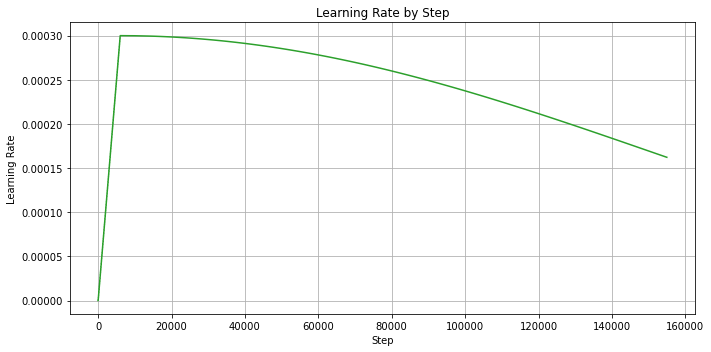

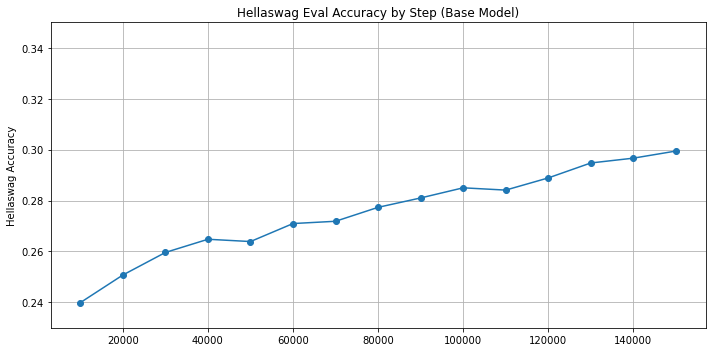

In [13]:
# Training Loss Figure


fig1, ax1 = plt.subplots(figsize=(10, 5), facecolor="white")
ax1.plot(
    df_metrics["step"],
    df_metrics["train_loss"],
    color="tab:blue",
    alpha=1,
    label="Train Loss",
)

ax1.plot(
    df_metrics["step"][df_metrics["val_loss"].notna()],
    df_metrics["val_loss"][df_metrics["val_loss"].notna()],
    color="tab:orange",
    label="Validation Loss",
    zorder=4,
    linewidth=3,
)
ax1.axhline(y=3.2, color='red', linestyle='--', label='Goal 3.2')
ax1.axhline(y=3.0, color='orangered', linestyle='--', label='Stretch Goal 3.0')

ax1.legend()
ax1.yaxis.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.xaxis.set_major_locator(mticker.AutoLocator())
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator())
ax1.xaxis.grid(True, which="both", linestyle=":", linewidth=0.5)
ax1.set_yscale("log")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True)
fig1.patch.set_facecolor("white")
plt.tight_layout()
plt.show()

# Learning Rate Figure
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(df_metrics["step"], df_metrics["lr"], color="tab:green")
ax2.set_xlabel("Step")
ax2.set_ylabel("Learning Rate")
ax2.set_title("Learning Rate by Step")
ax2.grid(True)
plt.tight_layout()
plt.show()

# Hellaswag Eval Accuracy Figure
fig3, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(
    df_metrics["step"][df_metrics["hellaswag_acc"].notna()],
    df_metrics["hellaswag_acc"][df_metrics["hellaswag_acc"].notna()],
    color="tab:blue",
    marker="o",
)
ax3.set_ylabel("Hellaswag Accuracy")
ax3.set_title("Hellaswag Eval Accuracy by Step (Base Model)")
ax3.grid(True)
ax3.set_ylim(bottom=0.23, top=0.35)
plt.tight_layout()
plt.show()

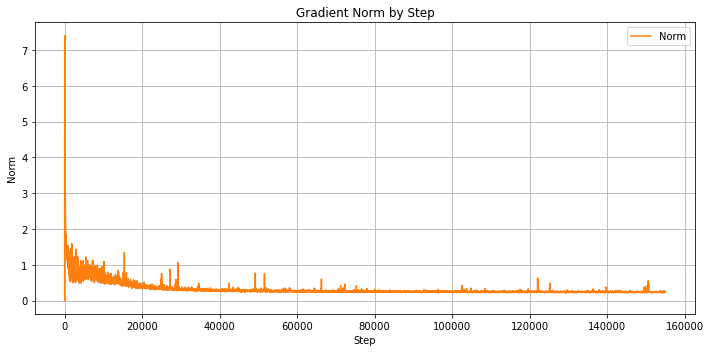

In [12]:
# Plot Norm
fig_norm, ax_norm = plt.subplots(figsize=(10, 5))
ax_norm.plot(df_metrics["step"], df_metrics["norm"], color="tab:orange", label="Norm")
ax_norm.set_xlabel("Step")
ax_norm.set_ylabel("Norm")
ax_norm.set_title("Gradient Norm by Step")
ax_norm.grid(True)
ax_norm.legend()
plt.tight_layout()
plt.show()